# Emukit - Bayesian Optimization with Non-Linear Constraints

This notebook demonstrates the use of emukit to perform Bayesian optimization with non-linear constraints. 

In Bayesian optimization we optimize an acquisition function to find the next point to evaluate the objective function:

$$
\mathbf{x}^* = \arg \min A(\mathbf{x})
$$

We now want to add some non-linear constraints to ensure that $g(\mathbf{x}^*) > 0$. To do this we use the `NonlinearInequalityConstraints` class provided by emukit.

In [1]:
FIG_SIZE = (12, 8)

# Objective

We will aim to optimize the 2D-Branin function.

In [2]:
from emukit.test_functions import branin_function
fcn, space = branin_function()

# Constraint function

Define constraints as a circle of raidus 4 centred at (3, 7).

In [3]:
import numpy as np
constraint_radius = 4
constraint_fcn = lambda x: 10 * (-(x[0] - 3)**2 - (x[1] - 7)**2 + constraint_radius ** 2)

optimum = np.array([[-np.pi, 12.275], [np.pi, 2.275], [9.42478, 2.475]])

# Plot objective with constraints

Constraint boundary is show in black, inside the circle the constraint is satisfied and outside it is violated. The red crosses show the location of the unconstrained optima.

In [4]:
# evaluate objective on grid to plot
x_1 = np.linspace(-5, 10, 50)
x_2 = np.linspace(0, 15, 51)
x_1_grid, x_2_grid = np.meshgrid(x_1, x_2)
x_all = np.stack([x_1_grid.flatten(), x_2_grid.flatten()], axis=1)
y_all = fcn(x_all)
y_reshape = np.reshape(y_all, x_1_grid.shape)

# evaluate constraint to plot
theta_constraint = np.linspace(0, 2*np.pi)
x_0_constraint = 3 + np.sin(theta_constraint) * constraint_radius
x_1_constraint = 7 + np.cos(theta_constraint) * constraint_radius

import matplotlib.pyplot as plt
plt.figure(figsize=FIG_SIZE)
plt.contourf(x_1, x_2, y_reshape)
plt.title('Branin Function')
plt.plot(x_0_constraint, x_1_constraint, linewidth=3, color='k')
plt.plot(optimum[:, 0], optimum[:, 1], marker='x', color='r', linestyle='')
plt.legend(['Constraint boundary', 'Unconstrained optima']);

# Gaussian process model

In [5]:
import GPy
from emukit.model_wrappers import GPyModelWrapper

x_init = np.array([[0, 7], [1, 9], [6, 8]])
y_init = fcn(x_init)

model = GPy.models.GPRegression(x_init, y_init)
emukit_model = GPyModelWrapper(model)

# Define Constraints

Create the `NonlinearInequalityConstraint` class represeting the $g(\mathbf{x}) > 0$ constraint.

In [6]:
from emukit.core.acquisition import Acquisition
from emukit.core.constraints import NonlinearInequalityConstraint
from scipy.special import expit # expit is scipy's sigmoid function

constraints = [NonlinearInequalityConstraint(constraint_fcn, 0, np.inf)]
space.constraints = constraints

# Create expected improvement acquisition function

In [7]:
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
ei = ExpectedImprovement(model)

# Plot function

This function will be called at the end of each iteration so we can see the progress of the optimization

In [8]:
def plot_progress(loop, loop_state):
    plt.figure(figsize=FIG_SIZE)
    plt.contourf(x_1, x_2, y_reshape)
    plt.plot(x_0_constraint, x_1_constraint, linewidth=3, color='k')
    plt.plot(loop_state.X[:-1, 0], loop_state.X[:-1, 1], linestyle='', marker='.', markersize=16, color='b')
    plt.plot(loop_state.X[-1, 0], loop_state.X[-1, 1], linestyle='', marker='.', markersize=16, color='r')
    plt.legend(['Constraint boundary', 'Previously evaluated points', 'Last evaluation'])

# Run optimization loop

Optimization restart 1/1, f = 14.84099333854313


 /Users/marpulli/miniconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/1, f = 19.20252126569826


 /Users/marpulli/miniconda3/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning:delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.


Optimization restart 1/1, f = 23.39297154162139
Optimization restart 1/1, f = 27.459621513163018
Optimization restart 1/1, f = 31.424738493843638


 /Users/marpulli/miniconda3/lib/python3.6/site-packages/GPy/kern/src/rbf.py:51: RuntimeWarning:overflow encountered in square
 /Users/marpulli/miniconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/marpulli/miniconda3/lib/python3.6/site-packages/GPy/kern/src/rbf.py:54: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/1, f = 34.48887098834988
Optimization restart 1/1, f = -4.654578962038498
Optimization restart 1/1, f = -1.2624651157487667
Optimization restart 1/1, f = 4.0871007012792955
Optimization restart 1/1, f = 6.410675778774355
Optimization restart 1/1, f = 10.112031606245996


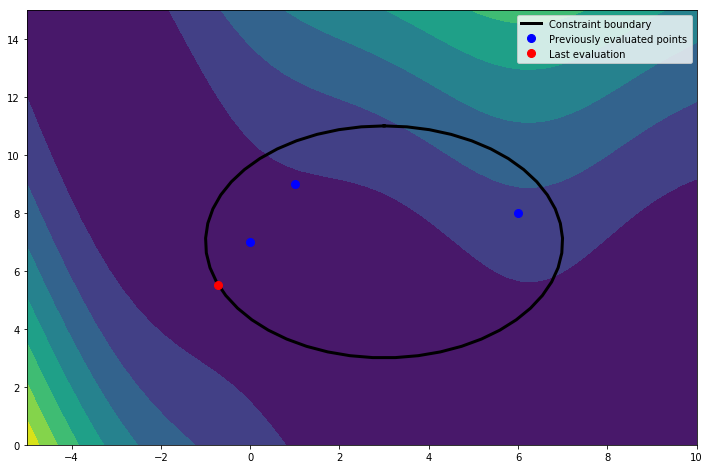

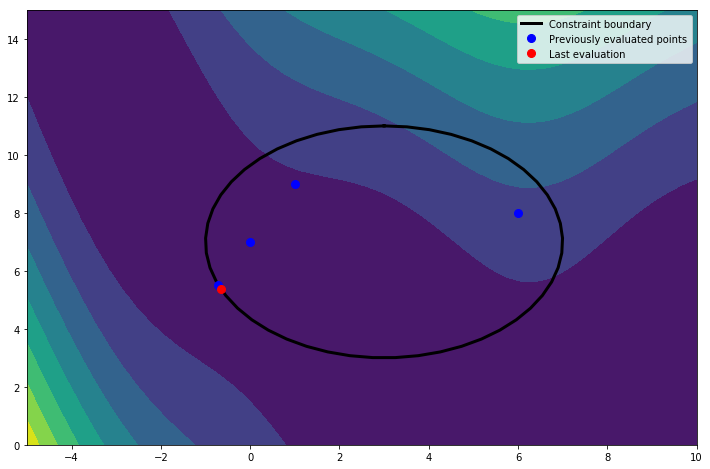

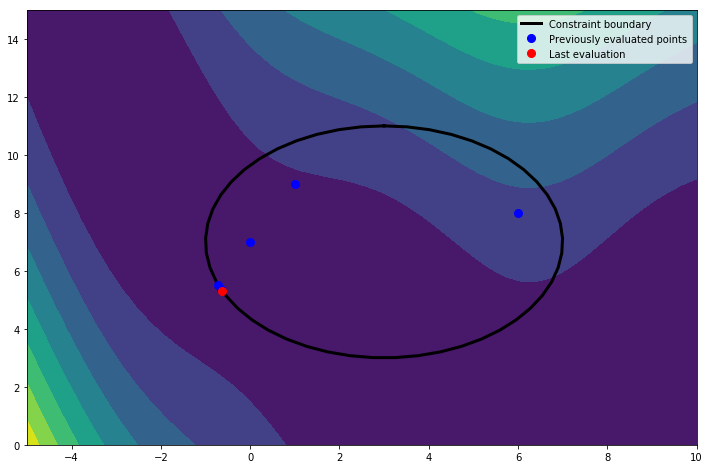

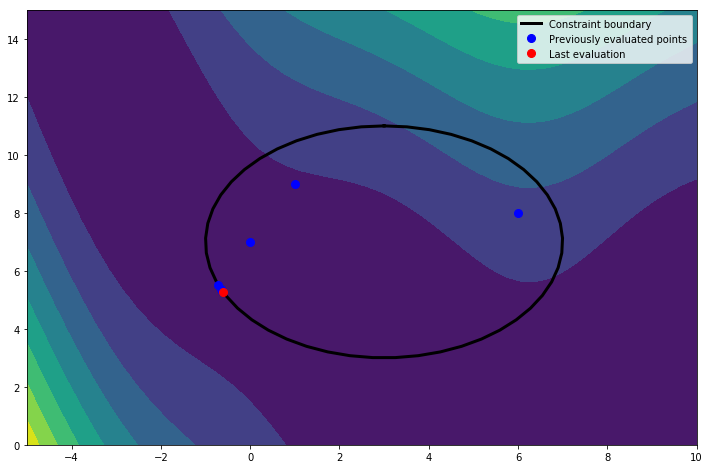

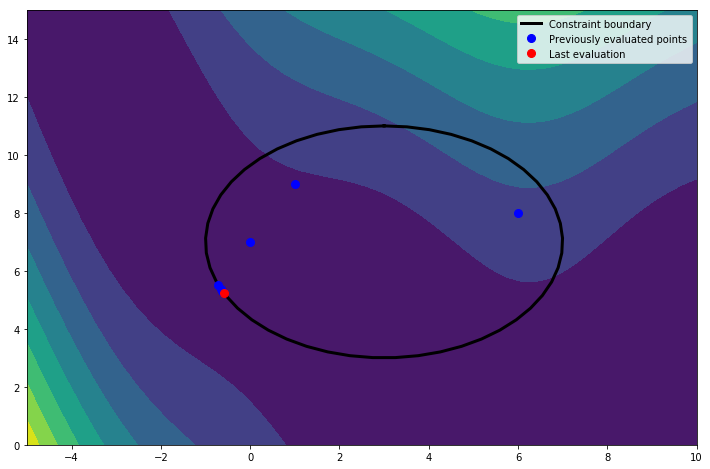

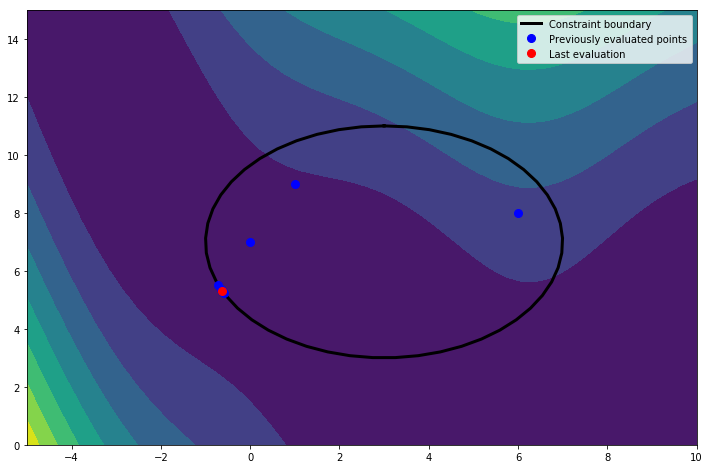

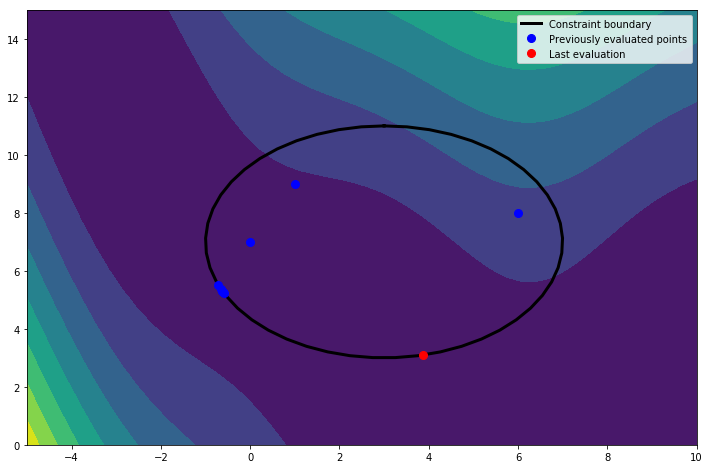

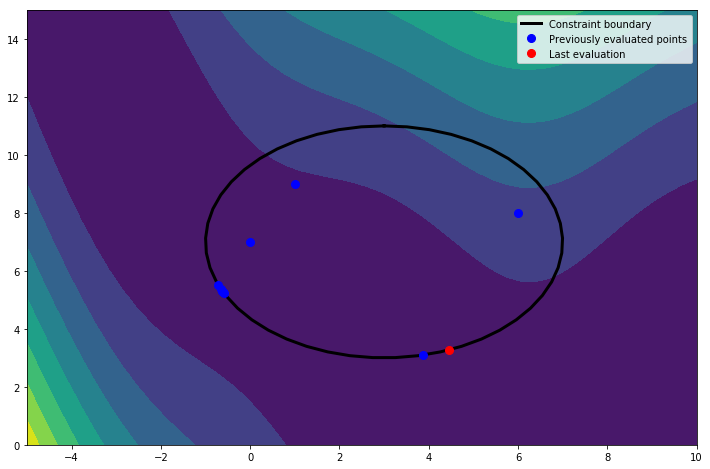

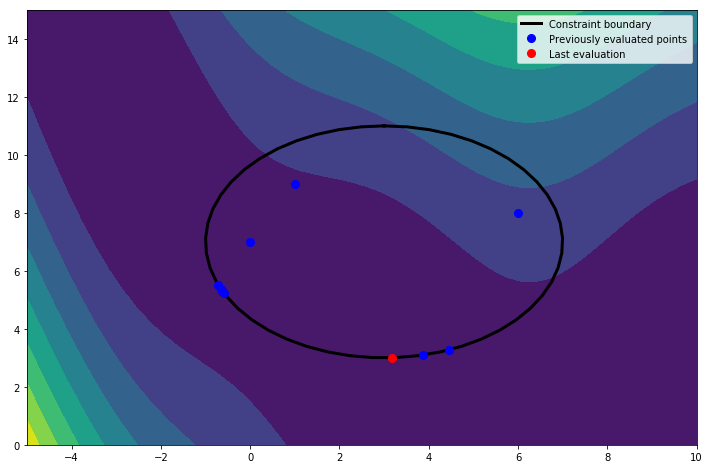

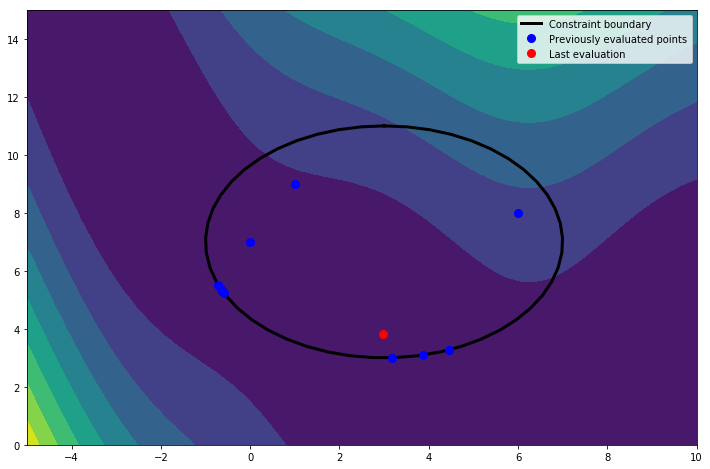

In [9]:
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.core.optimization import GradientAcquisitionOptimizer

# Create acquisition optimizer with constraints
acquisition_optimizer = GradientAcquisitionOptimizer(space)

# Make BO loop
bo_loop = BayesianOptimizationLoop(space, emukit_model, ei, acquisition_optimizer=acquisition_optimizer)
# append plot_progress function to iteration end event
bo_loop.iteration_end_event.append(plot_progress)
bo_loop.run_loop(fcn, 10)

We can see that all the points emukit chose to evaluate were inside the constraint!